## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
import tensorflow as tf
import keras.backend as K

def combined_loss(para, gamma=2., alpha=4.):
    
    gamma = float(gamma)
    alpha = float(alpha)
    
    """Define the customized loss."""
    def combined_loss_keras(y_true, y_pred):
        
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        
        ce = tf.multiply(y_true, -tf.math.log(model_out)) # cross entropy
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma)) # weight
        fl = tf.multiply(alpha, tf.multiply(weight, ce)) # focal_loss
        
        reduced_fl = tf.reduce_max(fl, axis=1) # reduced cross entropy
        reduced_ce = tf.reduce_max(ce, axis=1) # reduced focal_loss
#       ce_loss    = keras.losses.categorical_crossentropy(y_true, y_pred) # # 參考解答版本
        
        # 定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy (比例不要寫死)
        return tf.reduce_mean((1-para) * reduced_fl + (para) * reduced_ce)
#       return (ce_weights*ce_loss) + (fcl_weights*tf.reduce_mean(reduced_fl) ) # # 參考解答版本
    
    return combined_loss_keras


In [8]:
import itertools
results = {}



model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss = combined_loss(0.3), metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)
    
    # Collect results
train_loss=model.history.history["loss"]
valid_loss=model.history.history["val_loss"]
train_acc=model.history.history["accuracy"]
valid_acc=model.history.history["val_accuracy"]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

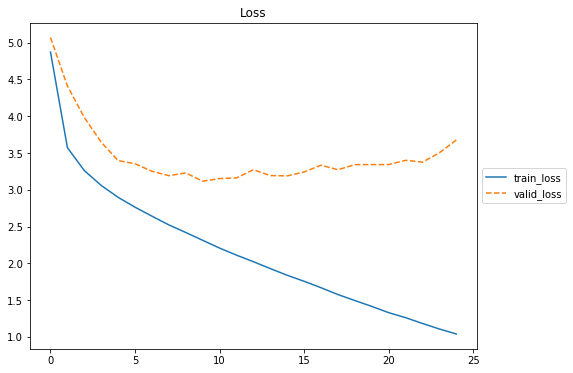

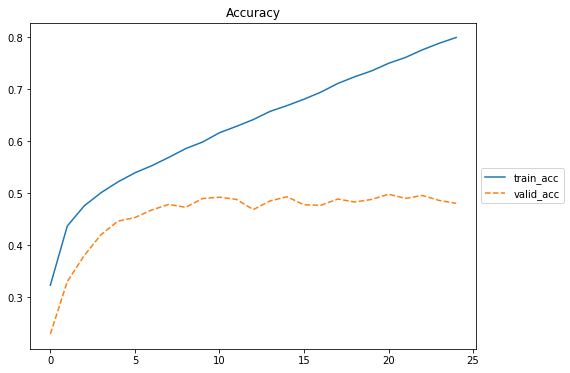

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))

plt.plot(range(len(train_loss)),train_loss, '-', label='train_loss')
plt.plot(range(len(valid_loss)),valid_loss, '--', label='valid_loss')
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))

plt.plot(range(len(train_acc)),train_acc, '-', label='train_acc')
plt.plot(range(len(valid_acc)),valid_acc, '--', label='valid_acc')
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()